## 1. Imports & Configuration

In [1]:
# %%
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
import joblib
import shap
from dotenv import load_dotenv

# Load Environment Variables
load_dotenv()

# Configuration
MONGO_URI = os.getenv('MONGO_URI')
DB_NAME = "aqi_db"
COLLECTION_NAME = "processed_data"

# Plotting Style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries Imported Successfully")

c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries Imported Successfully


## 2. Load Data from MongoDB

In [2]:
# %%
def load_data_from_mongo():
    print("⏳ Connecting to MongoDB...")
    client = pymongo.MongoClient(MONGO_URI)
    db = client[DB_NAME]
    collection = db[COLLECTION_NAME]
    
    # Fetch all data
    cursor = collection.find()
    df = pd.DataFrame(list(cursor))
    
    if df.empty:
        print("❌ No data found!")
        return None

    # Preprocessing
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        
    # Drop non-numeric/unnecessary columns for analysis
    drop_cols = ['_id', 'pm2_5', 'pm10', 'no2', 'so2', 'co', 'o3', 'calculated_aqi']
    df_clean = df.drop(columns=drop_cols, errors='ignore')
    
    print(f"✅ Loaded {len(df_clean)} records.")
    return df_clean

# Load the dataframe
df = load_data_from_mongo()
df.head()

⏳ Connecting to MongoDB...
✅ Loaded 4402 records.


,aqi,clouds,day,day_of_week,hour,humidity,month,pressure,temperature,wind_direction,...,aqi_lag_1,aqi_lag_6,aqi_lag_24,aqi_roll_mean_24,hour_sin,hour_cos,month_sin,month_cos,wind_sin,wind_cos
date,,,,,,,,,,,,,,,,,,,,,
2025-07-25 00:00:00,111.784925,40.0,25,4,0,83.0,7,996.0,28.37,270.0,...,109.987437,78.927897,93.838197,95.519966,0.000000,1.000000,-0.5,-0.866025,-1.000000e+00,-1.836970e-16
2025-07-25 01:00:00,113.213065,40.0,25,4,1,83.0,7,996.0,28.13,180.0,...,111.784925,85.846781,93.775107,96.329881,0.258819,0.965926,-0.5,-0.866025,1.224647e-16,-1.000000e+00
2025-07-25 02:00:00,115.552261,75.0,25,4,2,83.0,7,995.0,27.91,360.0,...,113.213065,91.335622,93.270386,97.258293,0.500000,0.866025,-0.5,-0.866025,-2.449294e-16,1.000000e+00
2025-07-25 03:00:00,118.433166,75.0,25,4,3,83.0,7,995.0,27.33,250.0,...,115.552261,96.487983,90.157940,98.436427,0.707107,0.707107,-0.5,-0.866025,-9.396926e-01,-3.420201e-01
2025-07-25 04:00:00,120.279899,75.0,25,4,4,83.0,7,995.0,27.45,290.0,...,118.433166,104.028643,90.284120,99.686251,0.866025,0.500000,-0.5,-0.866025,-9.396926e-01,3.420201e-01


## 3. EDA - Correlation Heatmap


c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


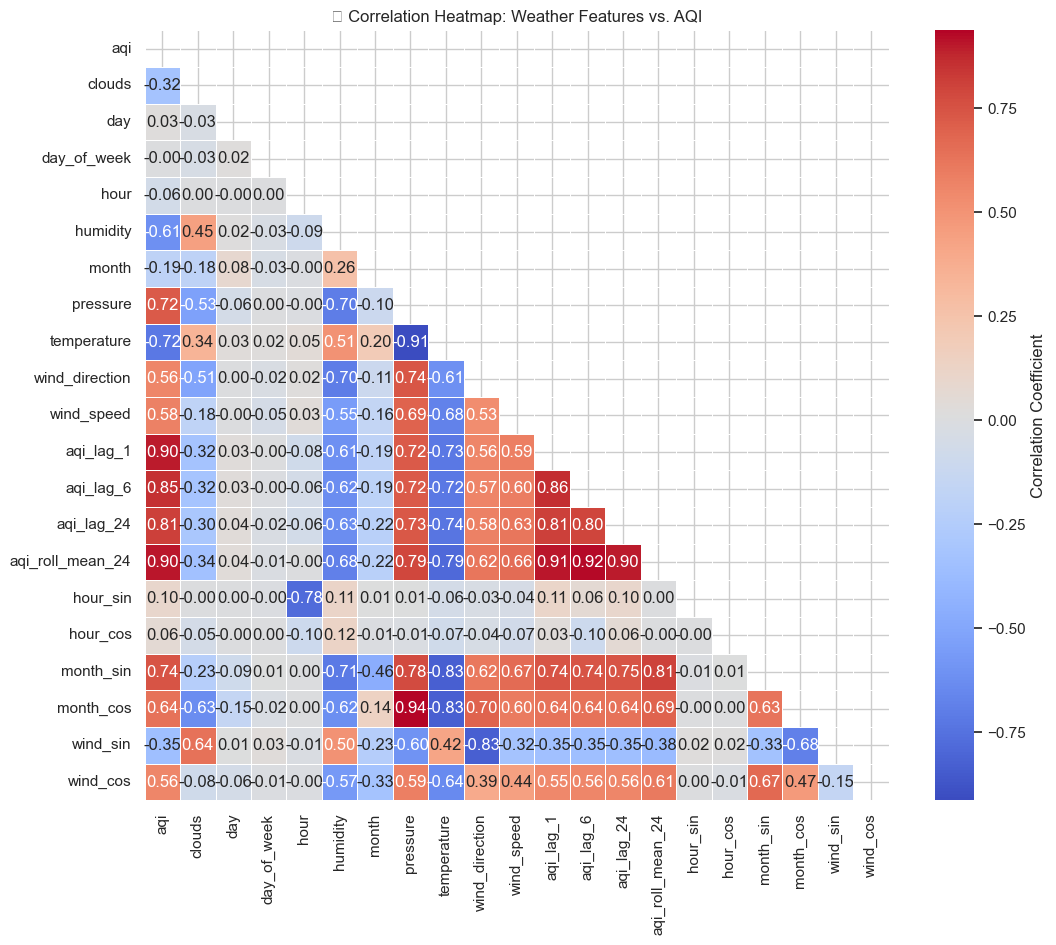

In [3]:
# %%
plt.figure(figsize=(12, 10))
correlation_matrix = df.select_dtypes(include='number').corr()

# Create a mask to hide the upper triangle (it's symmetrical)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})

plt.title("🔥 Correlation Heatmap: Weather Features vs. AQI")
plt.show()

## 4. EDA - Time Series Decomposition

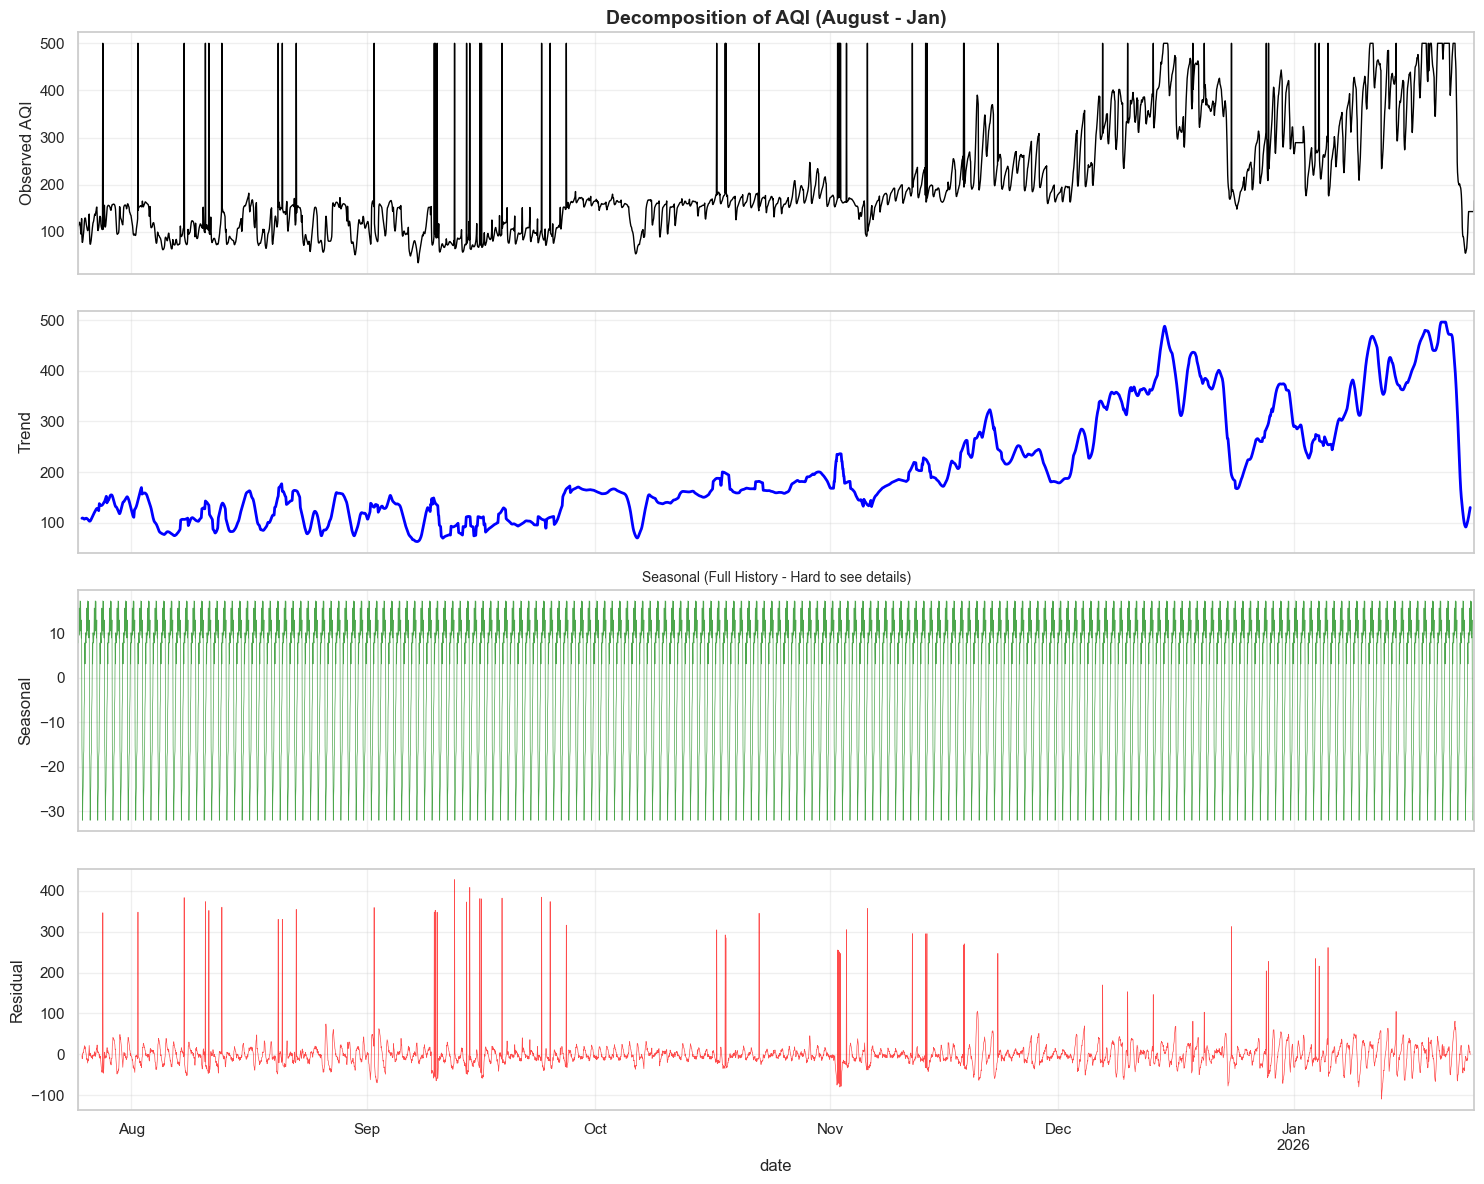

C:\Users\HP\AppData\Local\Temp\ipykernel_13804\3954031711.py:61: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


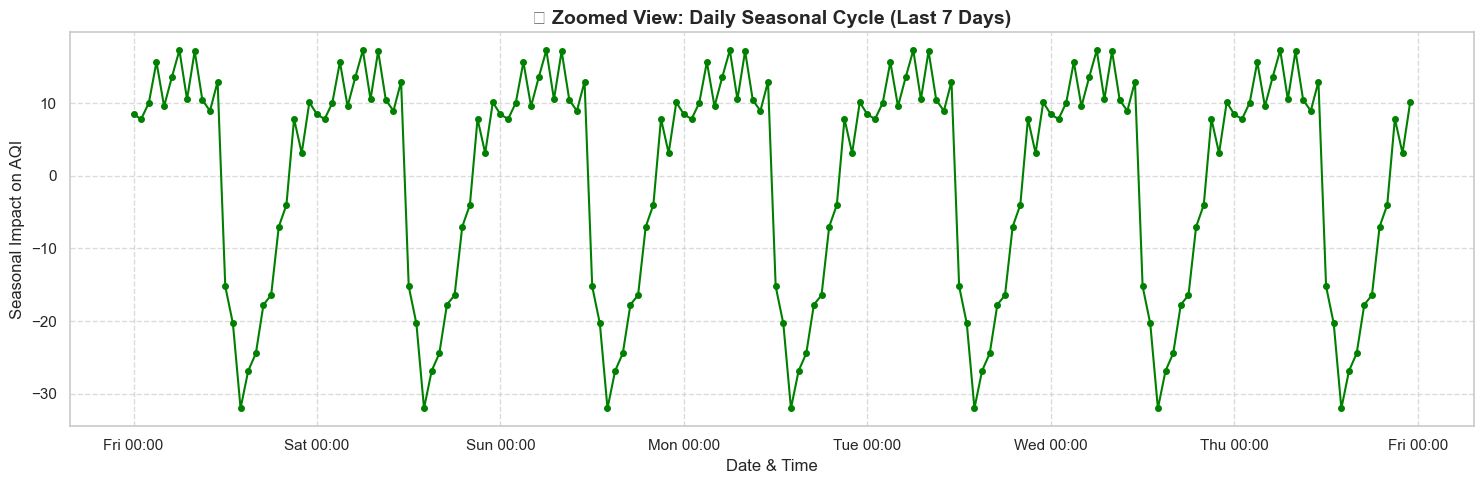

In [7]:
# %%
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

# 1. PRE-PROCESSING: REMOVE BAD FEB DATA
# Filter out data after Jan 31, 2026 (Removes the flat line)
df_clean = df[df.index < '2026-02-01'].copy()

# Resample to hourly to ensure no gaps
df_hourly = df_clean['aqi'].resample('h').mean().ffill()

try:
    # 2. PERFORM DECOMPOSITION
    decomposition = seasonal_decompose(df_hourly, model='additive', period=24) # 24 hours = 1 day

    # 3. PLOT 1: FULL OVERVIEW (Trend & Observed)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

    # Observed (Raw Data)
    decomposition.observed.plot(ax=ax1, color='black', linewidth=1)
    ax1.set_ylabel('Observed AQI')
    ax1.set_title('Decomposition of AQI (August - Jan)', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)

    # Trend (Long-term direction)
    decomposition.trend.plot(ax=ax2, color='blue', linewidth=2)
    ax2.set_ylabel('Trend')
    ax2.grid(True, alpha=0.3)

    # Seasonal (Repeating Pattern) - Showing full history here
    decomposition.seasonal.plot(ax=ax3, color='green', linewidth=0.5, alpha=0.7)
    ax3.set_ylabel('Seasonal')
    ax3.set_title("Seasonal (Full History - Hard to see details)", fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Residual (Noise)
    decomposition.resid.plot(ax=ax4, color='red', linewidth=0.5, alpha=0.7)
    ax4.set_ylabel('Residual')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # ---------------------------------------------------------
    # 4. PLOT 2: ZOOMED-IN SEASONALITY (Making it "Visible")
    # ---------------------------------------------------------
    
    # Take only the last 7 days (7 days * 24 hours = 168 hours)
    seasonal_zoom = decomposition.seasonal.head(168)
    
    plt.figure(figsize=(15, 5))
    plt.plot(seasonal_zoom.index, seasonal_zoom.values, color='green', marker='o', markersize=4)
    
    plt.title('🔍 Zoomed View: Daily Seasonal Cycle (Last 7 Days)', fontsize=14, fontweight='bold')
    plt.ylabel('Seasonal Impact on AQI')
    plt.xlabel('Date & Time')
    
    # Format x-axis to show Hour:Minute
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%a %H:%M'))
    plt.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Could not decompose: {e}")

## 5. SHAP - Feature Importance (Why is AQI high?)

In [5]:
# %%
import mlflow
import mlflow.xgboost
import mlflow.sklearn
import shap
import dagshub

# 1. Connect to DagsHub
DAGSHUB_USERNAME = os.getenv("DAGSHUB_USERNAME")
DAGSHUB_REPO = os.getenv("DAGSHUB_REPO")
DAGSHUB_TOKEN = os.getenv("DAGSHUB_TOKEN")

if not (DAGSHUB_USERNAME and DAGSHUB_REPO and DAGSHUB_TOKEN):
    raise ValueError("❌ Missing DagsHub credentials in .env file!")

print(f"🔌 Connecting to DagsHub: {DAGSHUB_REPO}...")
mlflow.set_tracking_uri(f"https://dagshub.com/{DAGSHUB_USERNAME}/{DAGSHUB_REPO}.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = DAGSHUB_USERNAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = DAGSHUB_TOKEN

# 2. Find and Load the Best Model
def load_best_model_for_shap():
    print("⏳ Scanning DagsHub Registry for best model...")
    client = mlflow.tracking.MlflowClient()
    # Ensure these match your registered model names
    model_names = ["XGBoost", "RandomForest", "RidgeRegression", "NeuralNetwork"] 
    
    best_model_name = None
    best_mae = float("inf")
    best_version = None

    # A. Find the winner
    for name in model_names:
        registered_name = name.replace(" ", "_")
        try:
            versions = client.search_model_versions(f"name='{registered_name}'")
            for v in versions:
                run = client.get_run(v.run_id)
                mae = float(run.data.metrics.get("mae", float("inf")))
                if mae < best_mae:
                    best_mae = mae
                    best_model_name = registered_name
                    best_version = v.version
        except:
            continue

    if not best_model_name:
        print("❌ No models found in registry.")
        return None

    print(f"🏆 Best Model: {best_model_name} v{best_version} (MAE: {best_mae:.2f})")
    
    # B. Load with the CORRECT Loader
    model_uri = f"models:/{best_model_name}/{best_version}"
    
    if "XGBoost" in best_model_name:
        print("⚡ Using XGBoost Loader...")
        return mlflow.xgboost.load_model(model_uri)
    else:
        print("🧠 Using Sklearn Loader...")
        return mlflow.sklearn.load_model(model_uri)

# 3. Load & Calculate SHAP
model = load_best_model_for_shap()

if model:
    # Prepare Data (Drop Target)
    X = df.drop(columns=['aqi'], errors='ignore')
    
    # SHAP is slow; use a small sample (e.g., 100 rows)
    X_sample = X.sample(n=min(100, len(X)), random_state=42)

    print("🧠 Calculating SHAP values... (This may take a moment)")
    
    # Create Explainer based on model type
    try:
        explainer = shap.Explainer(model, X_sample)
        shap_values = explainer(X_sample)
        print("✅ SHAP Analysis Ready.")
    except Exception as e:
        print(f"⚠️ SHAP Error: {e}")

🔌 Connecting to DagsHub: Lahore-AQI...
⏳ Scanning DagsHub Registry for best model...
🏆 Best Model: XGBoost v6 (MAE: 11.22)
⚡ Using XGBoost Loader...


🧠 Calculating SHAP values... (This may take a moment)
✅ SHAP Analysis Ready.


## 6. SHAP - Beeswarm Plot

C:\Users\HP\AppData\Local\Temp\ipykernel_13804\4243267562.py:5: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\HP\Documents\STUDY\Data Science\PROJECTS\10Pearls\aqi-predictor\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


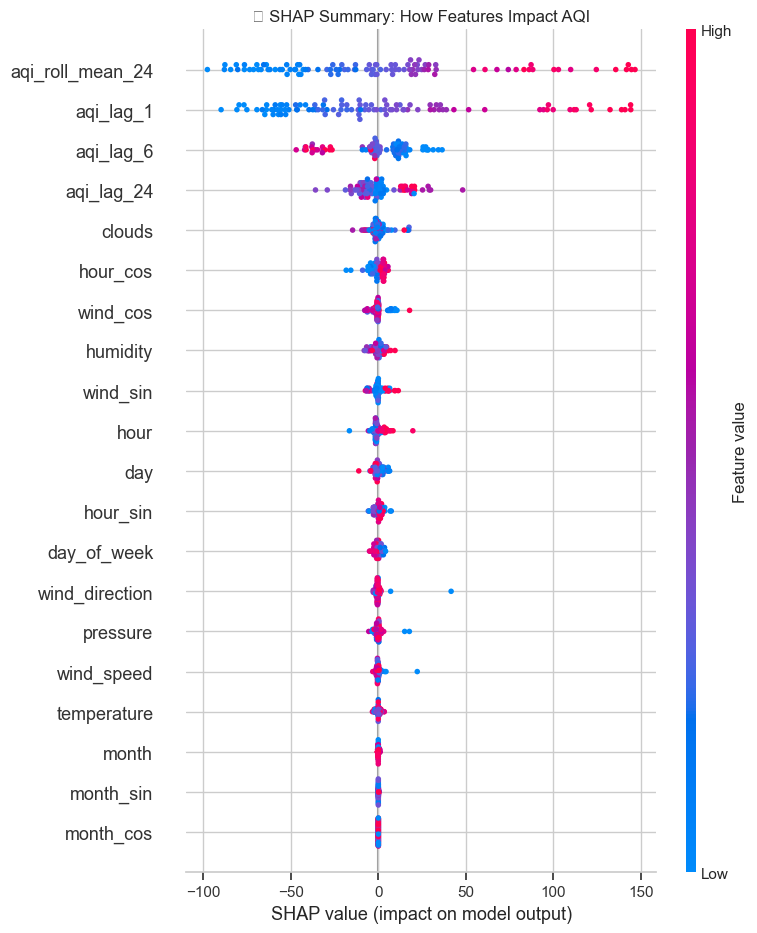

In [6]:
# %%
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("🧠 SHAP Summary: How Features Impact AQI")
plt.tight_layout()
plt.show()